In [93]:
import wandb
import sys

sys.path.append("../")
from src.models.bayesian_mlps import MixedStochasticMLP, compute_kl_distributions
from src.plotting.one_d_regression import plot_mean
from src.plotting.models import plot_kl_dict

from src.datamodules.toy_regression_datamodules import ToyRegressionADataModule

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns

import torch
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm
import copy

In [115]:
dm = ToyRegressionADataModule()
ddds_models = [MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_1_6999.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_2_6999.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_3_7999.ckpt")]

ddds_models_alt = [MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_alt_1.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_alt_2.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ddds_alt_3.ckpt")]

ssss_models = [
    MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ssss_1_9999.ckpt"),
    MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ssss_3_9999.ckpt")
]

ssss_models_alt = [MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ssss_alt_1.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ssss_alt_2.ckpt"),
               MixedStochasticMLP.load_from_checkpoint("vi_pathology_checkpoints/ssss_alt_3.ckpt")]

for models in [ddds_models, ddds_models_alt, dsds_models, ssss_models, ssss_models_alt]:
    for m in models:
        m.non_linearity = F.leaky_relu


In [116]:
def _compute_means(network, n_grid=500, n_mc=500):
    with torch.inference_mode():
        x_test = (
            torch.linspace(-3, 3, n_grid).reshape((n_grid, 1)).to(device=network.device)
        )
        mu_all = torch.zeros((n_grid, n_mc)).to(device=network.device)

        for i in tqdm(range(n_mc)):
            mu_i, _ = network.forward(x_test, mode="sample")
            mu_all[:, i] = mu_i.flatten()
        
        mu_all += 0.05*torch.rand_like(mu_all)

    x_test = x_test.detach().cpu().numpy()
    mu_all = mu_all.detach().cpu().numpy()
    return mu_all, x_test



# Main Plot for Paper

In [117]:
def create_frozen_model(base_model, threshold=0.1, sample_largest=True, sample_output_layer=True):
    new_model = copy.deepcopy(base_model)
    with torch.inference_mode():
        all_rhos = torch.cat((new_model.fc2.rho_weight.flatten().detach(),  new_model.fc2.rho_bias.flatten().detach(), 
                              new_model.fc3.rho_weight.flatten().detach(),  new_model.fc3.rho_bias.flatten().detach()))
        quantile = torch.quantile(all_rhos, threshold)
    
        if sample_largest:
            new_model.fc2.rho_weight.add_(-10000 * (new_model.fc2.rho_weight < quantile).float()) # weights with small variances set to mean
            new_model.fc2.rho_bias.add_(-10000 * (new_model.fc2.rho_bias < quantile).float())
            
            new_model.fc3.rho_weight.add_(-10000 * (new_model.fc3.rho_weight < quantile).float()) # weights with small variances set to mean
            new_model.fc3.rho_bias.add_(-10000 * (new_model.fc3.rho_bias < quantile).float())
        else:
            new_model.fc2.rho_weight.add_(-10000 * (new_model.fc2.rho_weight >= quantile).float()) # weights with large variances set to mean
            new_model.fc2.rho_bias.add_(-10000 * (new_model.fc2.rho_bias >= quantile).float())
            
            new_model.fc3.rho_weight.add_(-10000 * (new_model.fc3.rho_weight >= quantile).float()) # weights with large variances set to mean
            new_model.fc3.rho_bias.add_(-10000 * (new_model.fc3.rho_bias >= quantile).float())
    
    return new_model



100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1234.94it/s]


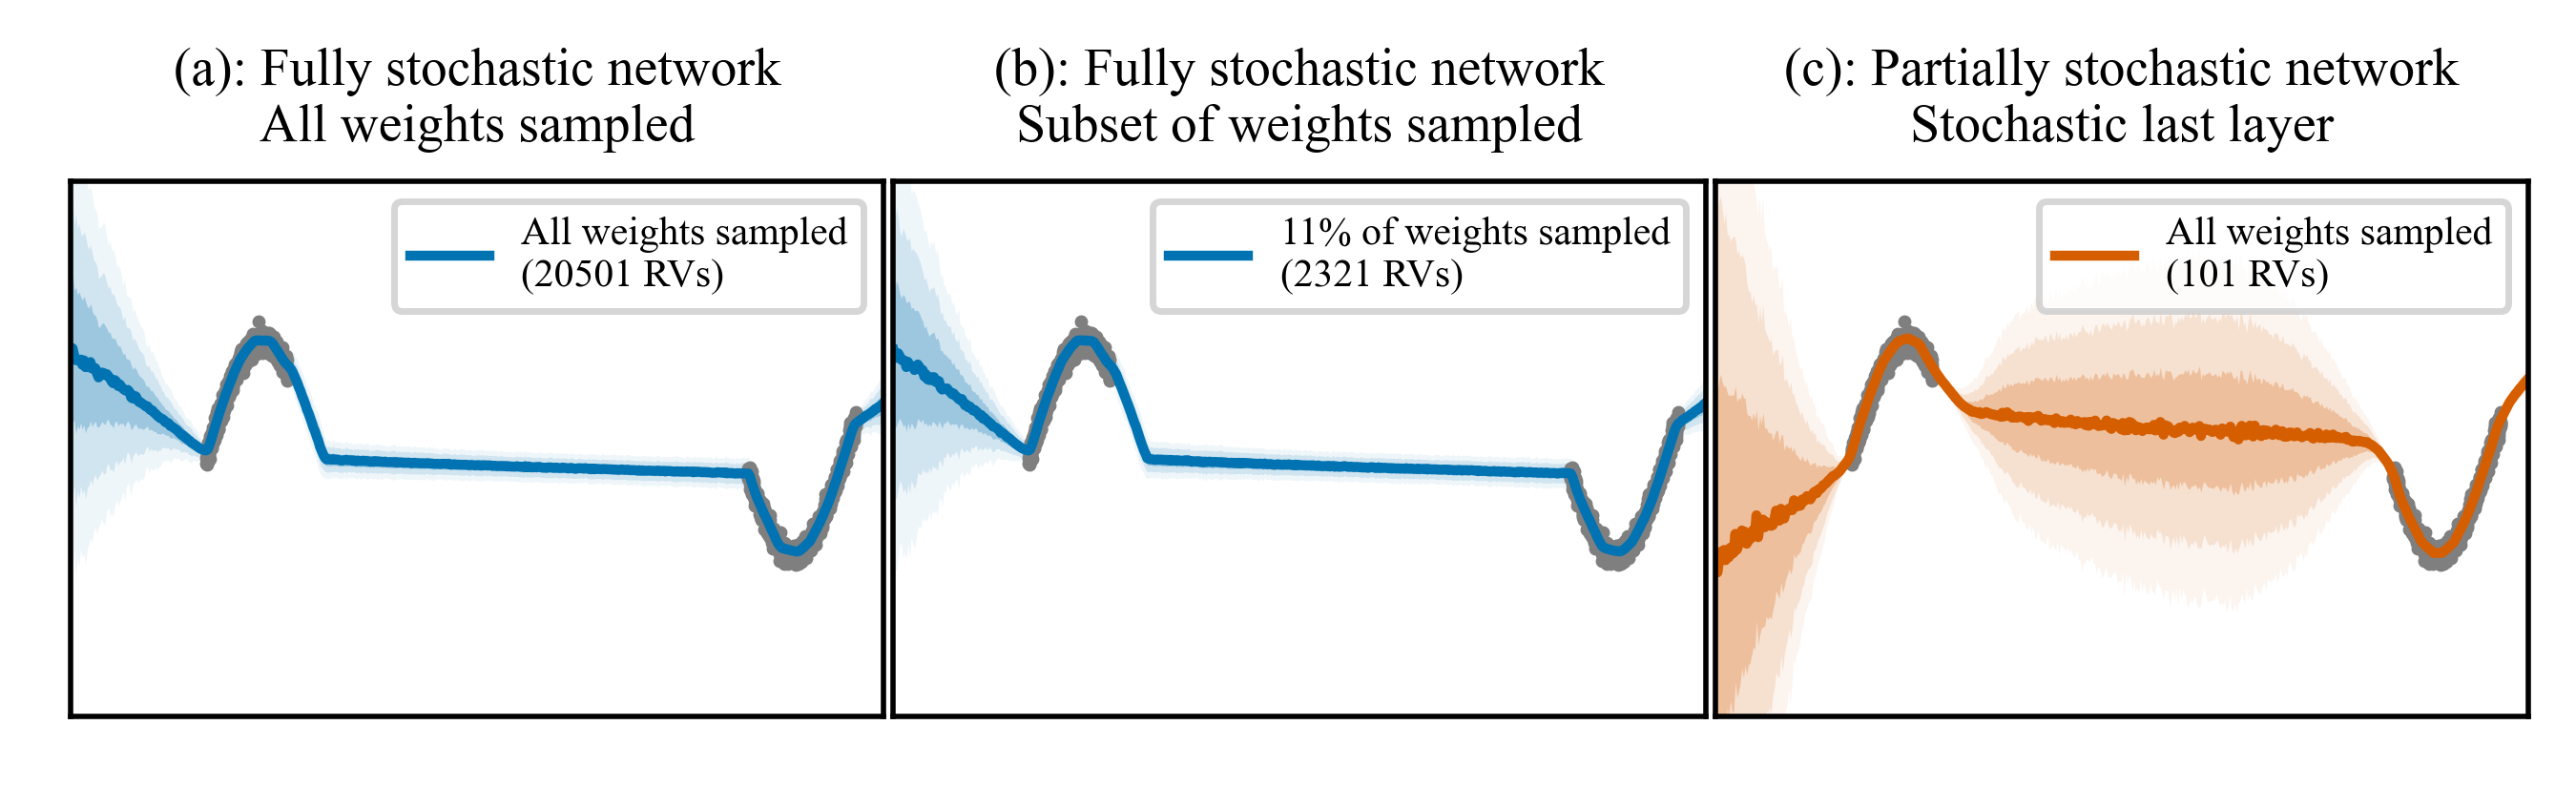

In [99]:
plt.figure(figsize=(5.5, 1.75), dpi=500)

plt.subplot(1, 3, 1)
mus, x_test = _compute_means(ssss_models[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="All weights sampled\n(20501 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(a): Fully stochastic network\nAll weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(1, 3, 2)
mus, x_test = _compute_means(create_frozen_model(ssss_models[0],  False))
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="11% of weights sampled\n(2321 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(b): Fully stochastic network\nSubset of weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(1, 3, 3)
mus, x_test = _compute_means(ddds_models[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[3], label="All weights sampled\n(101 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[3],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(c): Partially stochastic network\nStochastic last layer", fontsize=8)
plt.legend(fontsize=6)

plt.tight_layout(w_pad=-0.2)
plt.savefig("VI_issues_alt_two.pdf", bbox_inches="tight")

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1199.00it/s]


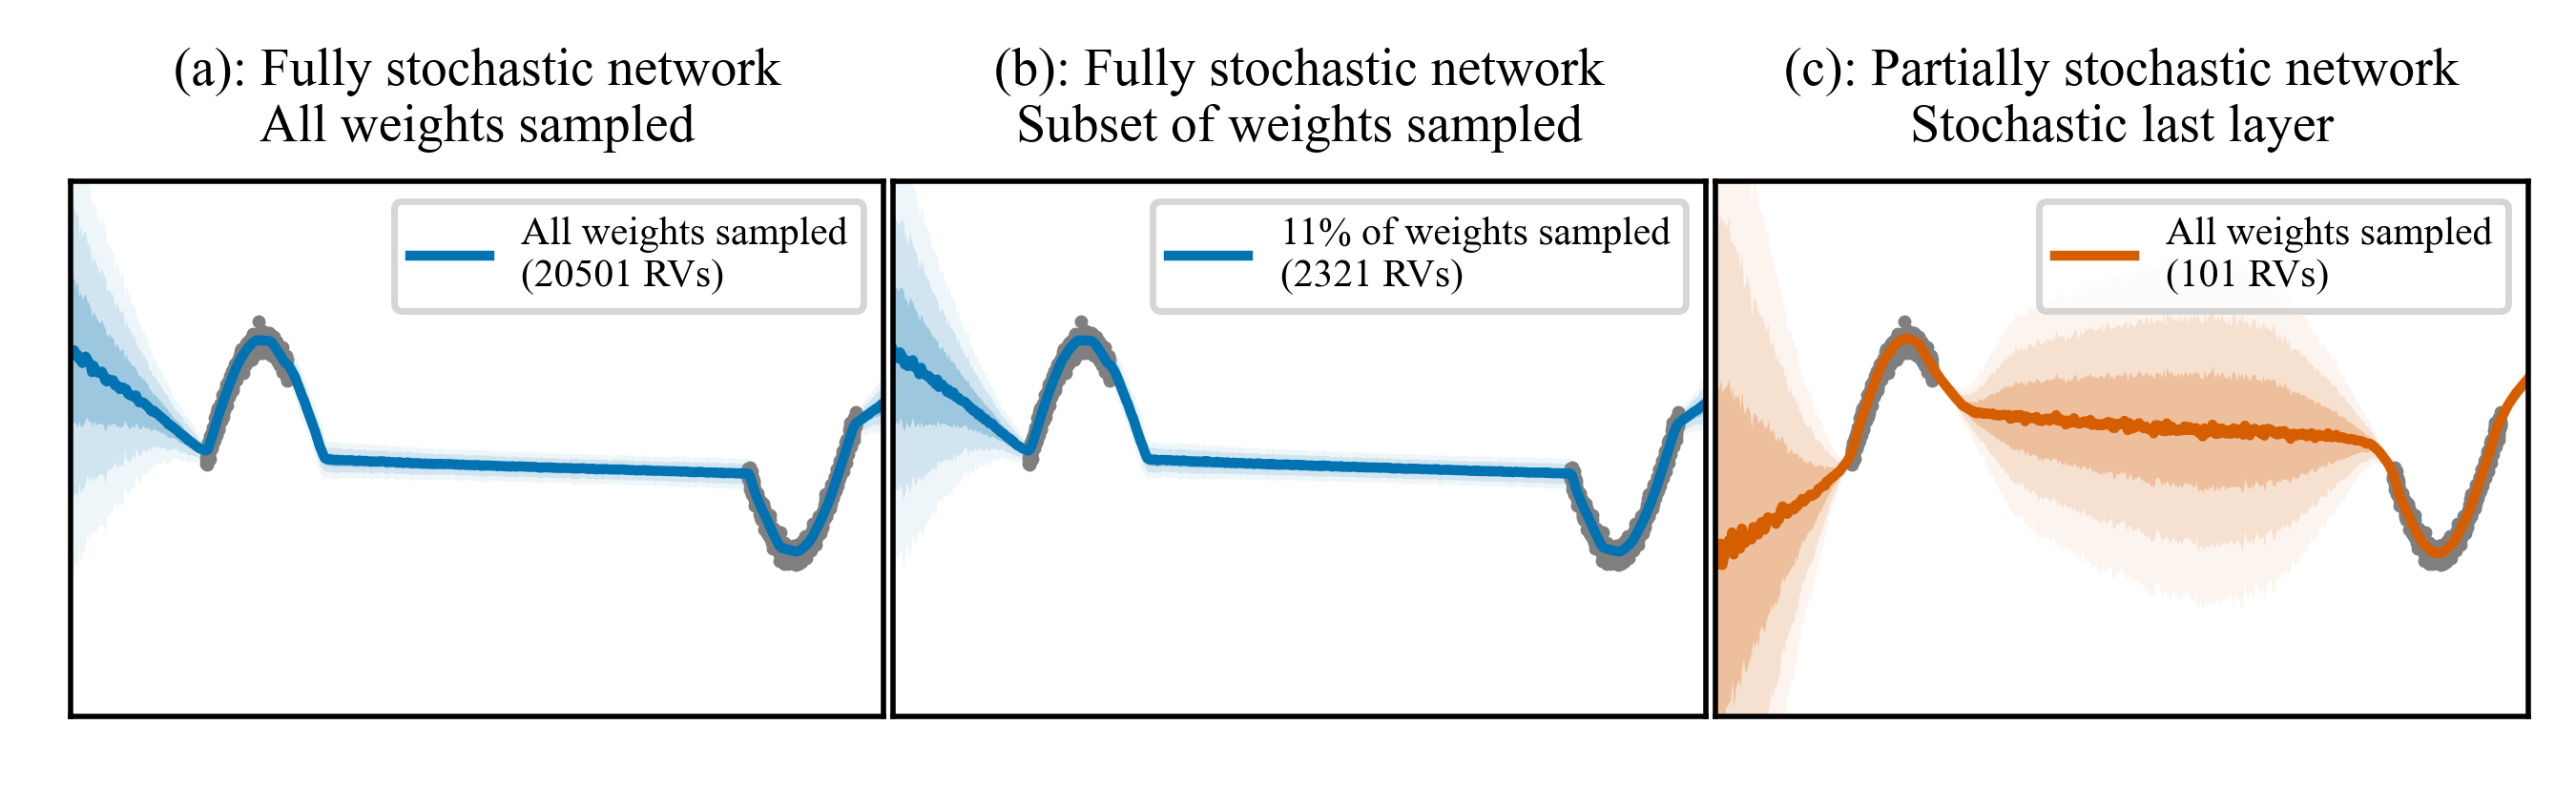

In [104]:
plt.figure(figsize=(5.5, 1.75), dpi=500)

plt.subplot(1, 3, 1)
mus, x_test = _compute_means(ssss_models[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="All weights sampled\n(20501 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(a): Fully stochastic network\nAll weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(1, 3, 2)
mus, x_test = _compute_means(create_frozen_model(ssss_models[0],  False))
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="11% of weights sampled\n(2321 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(b): Fully stochastic network\nSubset of weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(1, 3, 3)
mus, x_test = _compute_means(ddds_models[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[3], label="All weights sampled\n(101 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[3],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("(c): Partially stochastic network\nStochastic last layer", fontsize=8)
plt.legend(fontsize=6)

plt.tight_layout(w_pad=-0.2)
plt.savefig("VI_issues_alt_two.pdf", bbox_inches="tight")

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1184.96it/s]


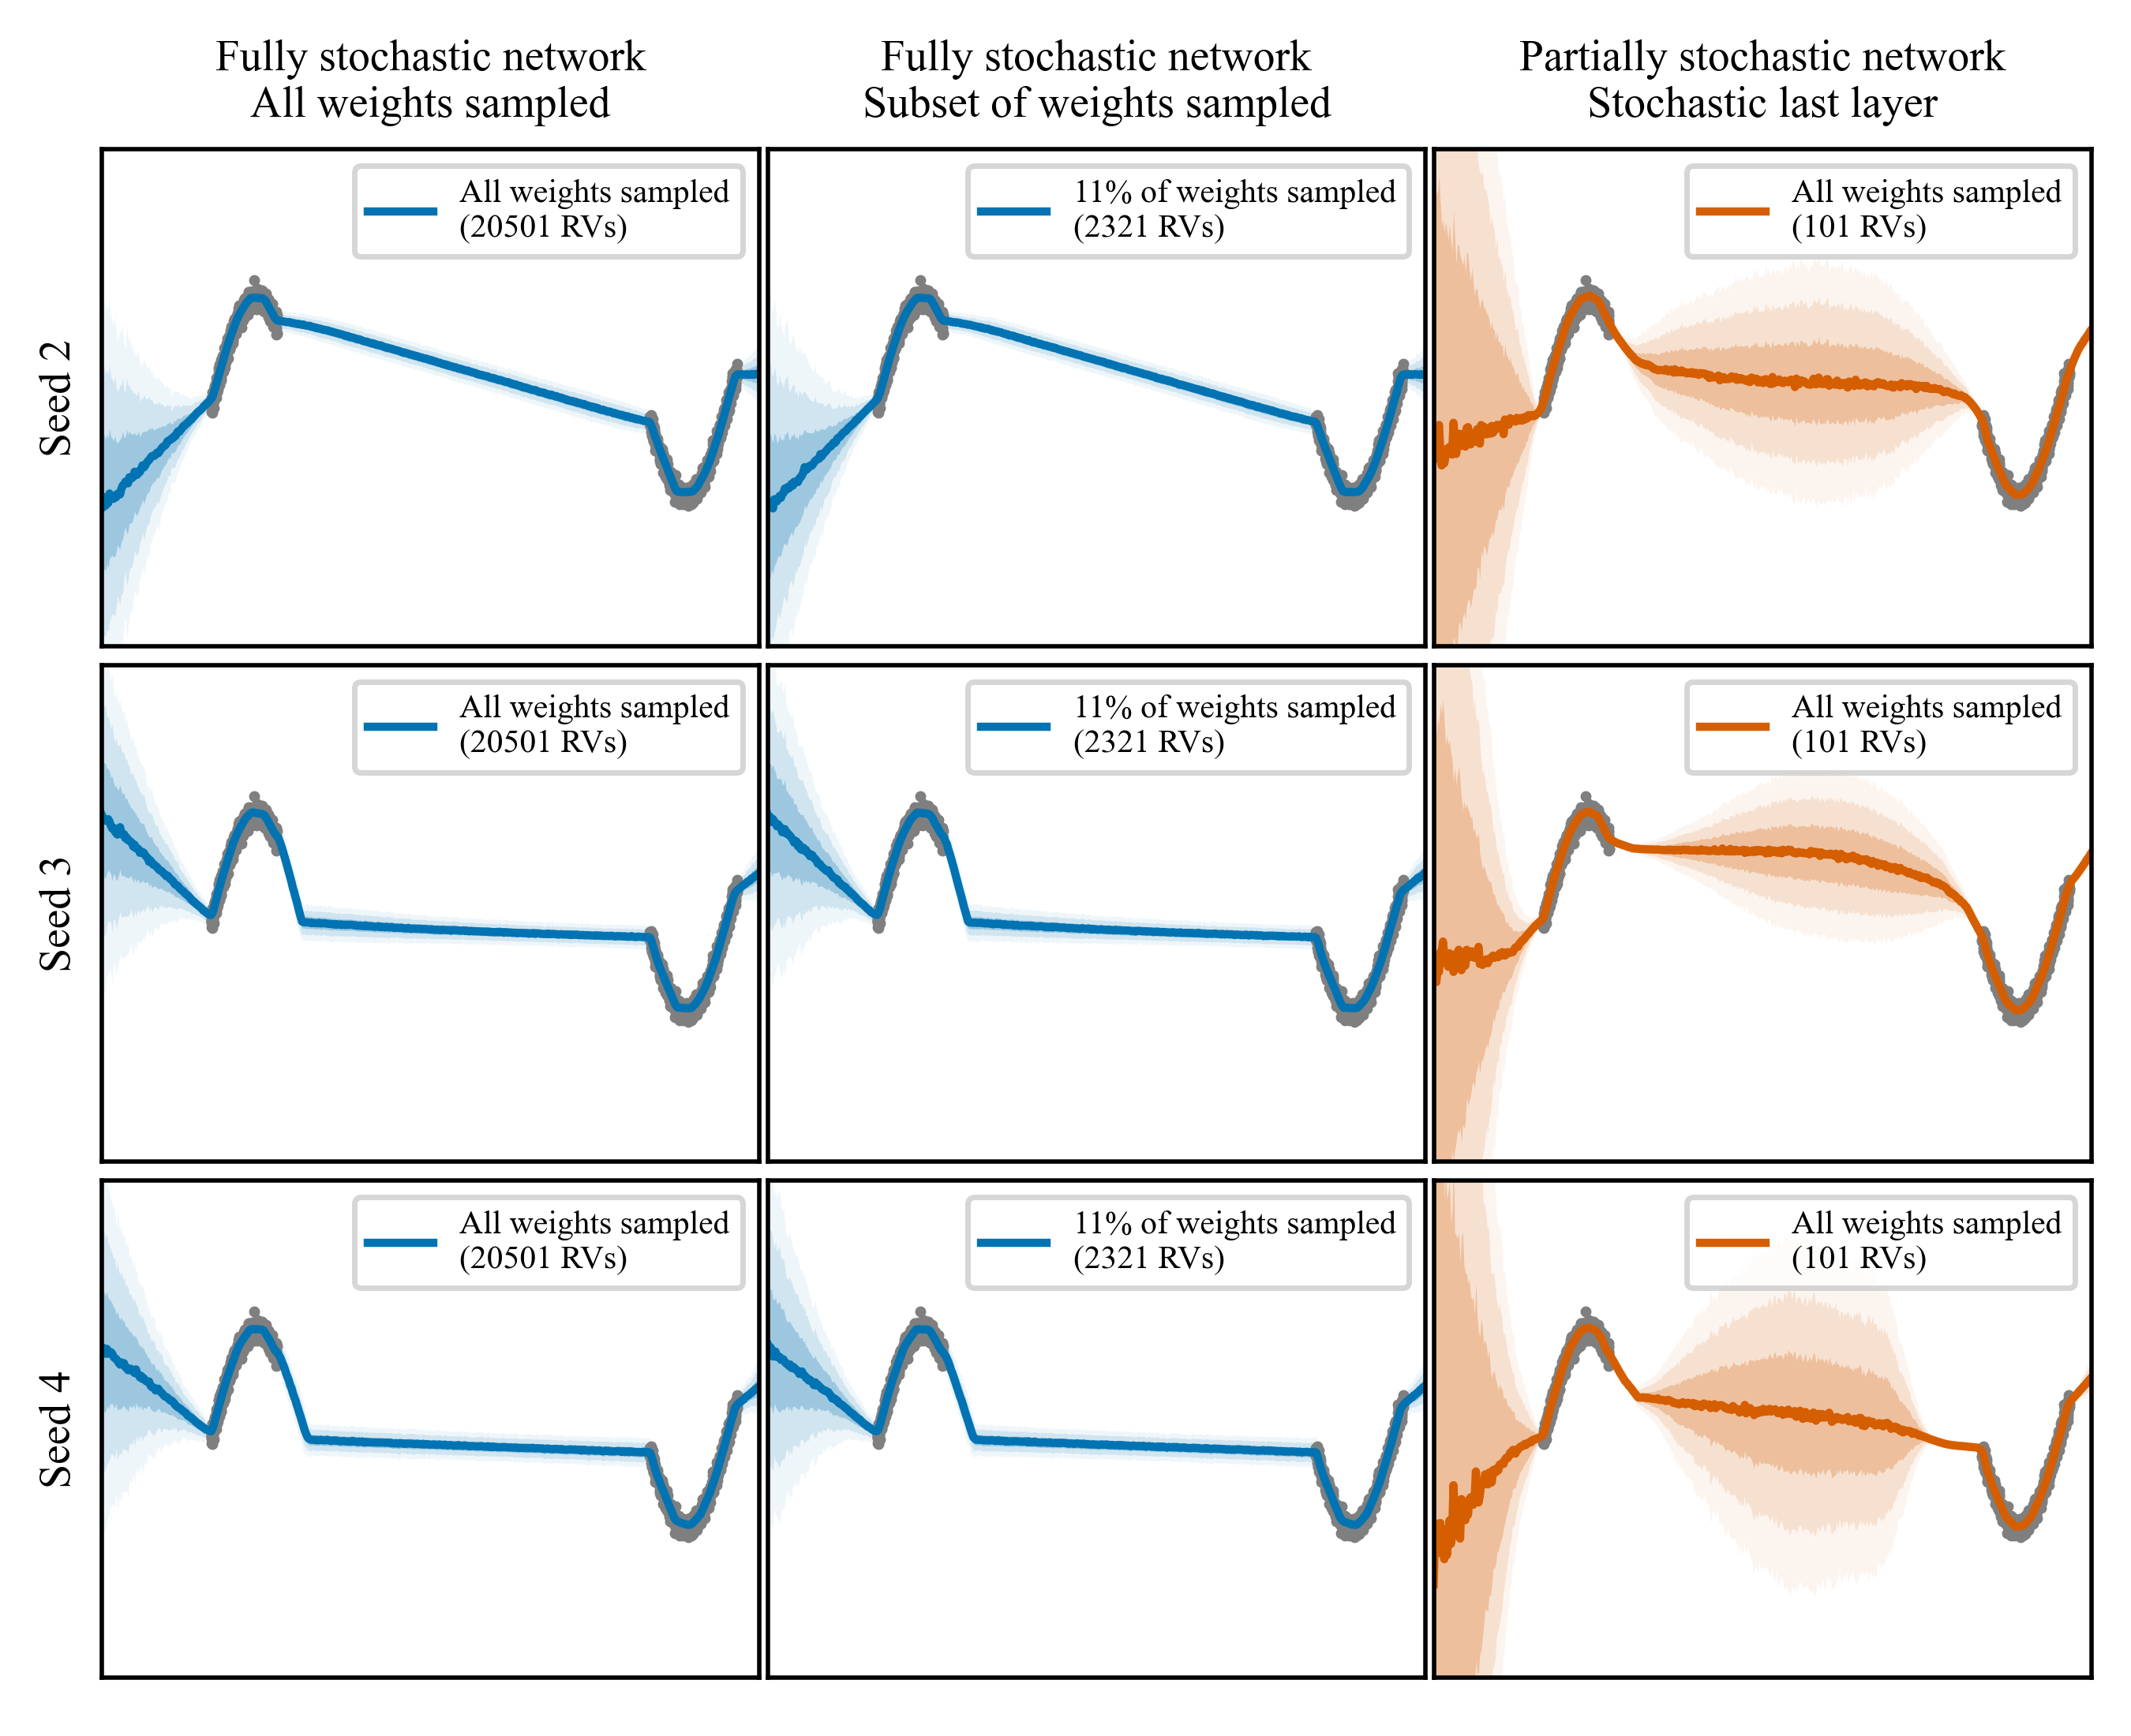

In [120]:
plt.figure(figsize=(5.5, 4.5), dpi=500)

plt.subplot(3, 3, 1)
mus, x_test = _compute_means(ssss_models_alt[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="All weights sampled\n(20501 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel("Seed 2", fontsize=8)
plt.title("Fully stochastic network\nAll weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 2)
mus, x_test = _compute_means(create_frozen_model(ssss_models_alt[0],  False))
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="11% of weights sampled\n(2321 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("Fully stochastic network\nSubset of weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 3)
mus, x_test = _compute_means(ddds_models_alt[0])
plt.plot(x_test, mus.mean(axis=-1), color=colors[3], label="All weights sampled\n(101 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[3],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
plt.title("Partially stochastic network\nStochastic last layer", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 4)
mus, x_test = _compute_means(ssss_models_alt[1])
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="All weights sampled\n(20501 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel("Seed 3", fontsize=8)
# plt.title("(a): Fully stochastic network\nAll weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 5)
mus, x_test = _compute_means(create_frozen_model(ssss_models_alt[1],  False))
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="11% of weights sampled\n(2321 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
# plt.title("(b): Fully stochastic network\nSubset of weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 6)
mus, x_test = _compute_means(ddds_models_alt[1])
plt.plot(x_test, mus.mean(axis=-1), color=colors[3], label="All weights sampled\n(101 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[3],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
# plt.title("(c): Partially stochastic network\nStochastic last layer", fontsize=8)
plt.legend(fontsize=6)


plt.subplot(3, 3, 7)
mus, x_test = _compute_means(ssss_models_alt[2])
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="All weights sampled\n(20501 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel("Seed 4", fontsize=8)
# plt.title("(a): Fully stochastic network\nAll weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 8)
mus, x_test = _compute_means(create_frozen_model(ssss_models_alt[2],  False))
plt.plot(x_test, mus.mean(axis=-1), color=colors[0], label="11% of weights sampled\n(2321 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[0],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[0],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
# plt.title("(b): Fully stochastic network\nSubset of weights sampled", fontsize=8)
plt.legend(fontsize=6)

plt.subplot(3, 3, 9)
mus, x_test = _compute_means(ddds_models_alt[2])
plt.plot(x_test, mus.mean(axis=-1), color=colors[3], label="All weights sampled\n(101 RVs)")
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 1 * mus.std(axis=-1),
    mus.mean(axis=-1) + 1 * mus.std(axis=-1),
    alpha=0.25,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 2 * mus.std(axis=-1),
    mus.mean(axis=-1) + 2 * mus.std(axis=-1),
    alpha=0.125,
    color=colors[3],
    linewidth=0
)
plt.fill_between(
    x_test.flatten(),
    mus.mean(axis=-1) - 3 * mus.std(axis=-1),
    mus.mean(axis=-1) + 3 * mus.std(axis=-1),
    alpha=0.0625,
    color=colors[3],
    linewidth=0
)

plt.scatter(
        dm.train_dataloader().dataset.X,
        dm.train_dataloader().dataset.Y,
        s=1,
        color="tab:gray",
    )

plt.xlim(-3, 3)
plt.xticks([])
plt.ylim((-2.5, 2.5))
plt.yticks([])
plt.xlabel(None, fontsize=8)
plt.ylabel(None, fontsize=8)
# plt.title("(c): Partially stochastic network\nStochastic last layer", fontsize=8)
plt.legend(fontsize=6)

plt.tight_layout(w_pad=-0.2, h_pad=0)
plt.savefig("VI_issues_more_seed.pdf", bbox_inches="tight")